# Projeto FarmTech Solutions - Fase 4
**Aluno:** Tiago Ribeiro Mercedes Valença  
**RM:** 565890  

Notebook para **Entrega 1**: EDA, Clusterização e Modelagem Preditiva do rendimento (Yield) com base em clima/solo.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"figure.dpi": 110})


## 1) Carregamento do Dataset e Padronização de Colunas
Tenta carregar de `data/raw/crop_yield.csv` e, se não existir, tenta `./crop_yield.csv`.
Renomeia as colunas para nomes simples em português.

In [3]:
import os

candidates = [
    'data/raw/crop_yield.csv',
    './crop_yield.csv'
]

path = None
for p in candidates:
    if os.path.exists(p):
        path = p
        break

if path is None:
    raise FileNotFoundError('Não encontrei crop_yield.csv em data/raw/ nem no diretório atual.')

df = pd.read_csv(path)

df = df.rename(columns={
    'Crop': 'Cultura',
    'Precipitation (mm day-1)': 'Precipitacao',
    'Specific Humidity at 2 Meters (g/kg)': 'Umidade_especifica',
    'Relative Humidity at 2 Meters (%)': 'Umidade_relativa',
    'Temperature at 2 Meters (C)': 'Temperatura',
    'Yield': 'Rendimento'
})

display(df.head())
df.columns


,Cultura,Precipitacao,Umidade_especifica,Umidade_relativa,Temperatura,Rendimento
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


Index(['Cultura', 'Precipitacao', 'Umidade_especifica', 'Umidade_relativa',
       'Temperatura', 'Rendimento'],
      dtype='object')

## 2) EDA – Análise Exploratória
- Estatísticas, tipos, contagem por cultura, distribuições e correlações.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cultura             156 non-null    object 
 1   Precipitacao        156 non-null    float64
 2   Umidade_especifica  156 non-null    float64
 3   Umidade_relativa    156 non-null    float64
 4   Temperatura         156 non-null    float64
 5   Rendimento          156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


None

,Cultura,Precipitacao,Umidade_especifica,Umidade_relativa,Temperatura,Rendimento
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000


Cultura
Cocoa, beans       39
Oil palm fruit     39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64

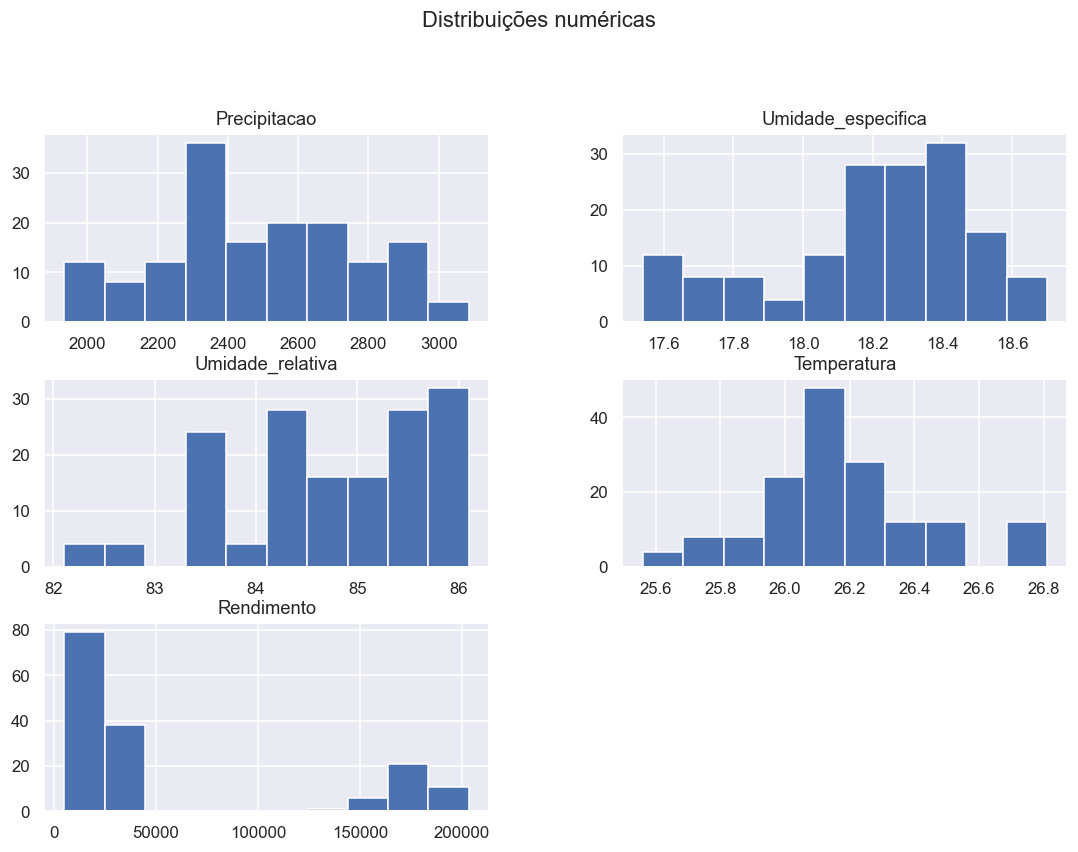

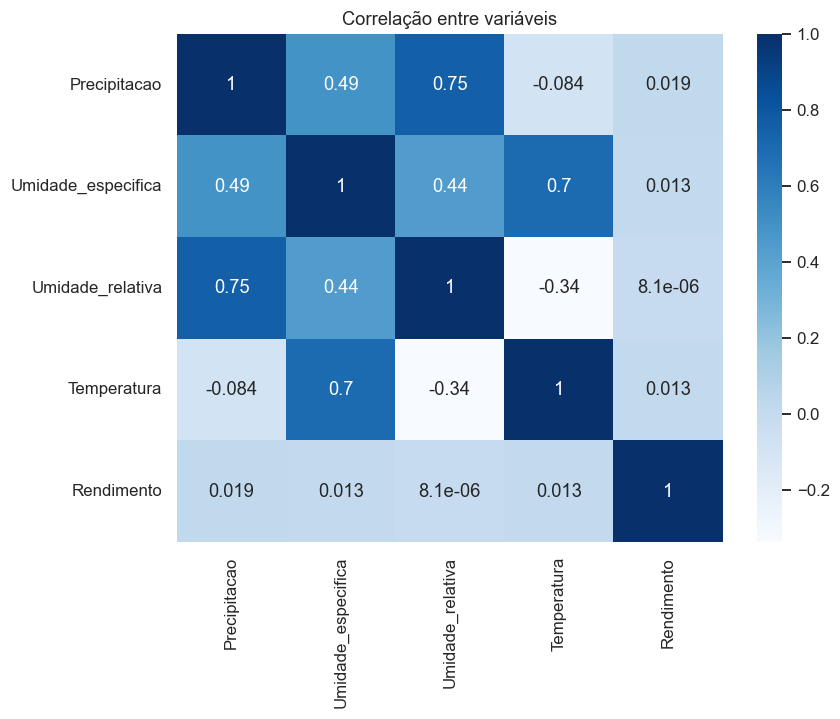

In [4]:
# Informações gerais e estatísticas
display(df.info())
display(df.describe(include='all'))
display(df['Cultura'].value_counts())

# Histogramas das variáveis numéricas
_ = df[['Precipitacao','Umidade_especifica','Umidade_relativa','Temperatura','Rendimento']].hist(figsize=(12,8))
plt.suptitle('Distribuições numéricas', y=1.02)
plt.show()

# Correlação numérica
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['Precipitacao','Umidade_especifica','Umidade_relativa','Temperatura','Rendimento']].corr(numeric_only=True),
    annot=True,
    cmap="Blues"
)
plt.title('Correlação entre variáveis')
plt.show()


## 3) Clusterização – Tendências e Outliers
Usa `KMeans` para agrupar padrões e `DBSCAN` para detectar outliers. PCA para visualização 2D.

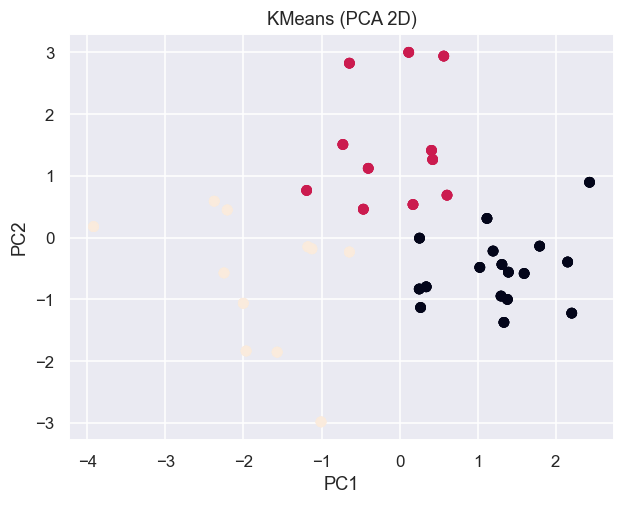

,Cluster,DBSCAN_label
0,2,0
1,2,-1
2,2,0
3,2,0
4,2,0


In [5]:
# Encode da cultura
le = LabelEncoder()
df_cluster = df.copy()
df_cluster['Cultura_encoded'] = le.fit_transform(df_cluster['Cultura'])

# Seleção de variáveis para clusterização
Xc = df_cluster[['Precipitacao','Umidade_especifica','Umidade_relativa','Temperatura','Cultura_encoded']]

# Padronização
scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(Xc)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(Xc_scaled)
df_cluster['Cluster'] = labels

# PCA para visualização 2D
pca = PCA(n_components=2)
Xp = pca.fit_transform(Xc_scaled)

plt.figure()
plt.scatter(Xp[:,0], Xp[:,1], c=labels)
plt.title("KMeans (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# DBSCAN para outliers
db = DBSCAN(eps=1.5, min_samples=5)
db_labels = db.fit_predict(Xc_scaled)
df_cluster['DBSCAN_label'] = db_labels  # -1 = outlier

df_cluster[['Cluster','DBSCAN_label']].head()


## 4) Modelagem Preditiva (5+ modelos)
Alvo (`y`): **Rendimento**. Atributos (`X`): clima/umidade/temperatura/chuva e **Cultura** codificada.

In [6]:
# Preparação para modelagem
df_model = df.copy()
df_model['Cultura_encoded'] = le.fit_transform(df_model['Cultura'])

X = df_model[['Precipitacao','Umidade_especifica','Umidade_relativa','Temperatura','Cultura_encoded']]
y = df_model['Rendimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Resultados
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
    mae = float(mean_absolute_error(y_test, preds))
    r2 = float(r2_score(y_test, preds))
    rows.append([name, rmse, mae, r2])

results_df = pd.DataFrame(rows, columns=['Modelo','RMSE','MAE','R²']).sort_values('RMSE')
results_df


,Modelo,RMSE,MAE,R²
4,Random Forest,4640.261954,2748.052188,0.994449
3,Decision Tree,4967.265347,3059.281250,0.993639
1,Ridge,64294.743878,53321.792381,-0.065698
2,Lasso,64603.206066,53454.572363,-0.075949
0,Linear Regression,65364.569016,53724.485077,-0.101459
5,SVR,71313.670885,38974.583615,-0.311079


## 5) Conclusões


In [ ]:
import sys, sklearn, pandas as pd, numpy as np, matplotlib

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)


> Atualizado: 2025-09-10 00:55:52